In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data ** other.data, (self, other), f'**')

    def _backward():
        self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
        if self.data > 0:  # log is only valid for positive bases
            other.grad += (self.data ** other.data) * math.log(self.data) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def sigmoid(self):
    x = self.data
    s = 1/(1 + math.exp(-x))
    out = Value(s, (self, ), 'sigmoid')
    
    def _backward():
      self.grad += s * (1 - s) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
g = Value(3.0, label='g')
L = d*f + g; L.label = 'L'
L

Value(data=-5.0)

In [4]:
L.backward()

In [5]:
a.grad, b.grad, c.grad, d.grad, e.grad, f.grad, g.grad

(6.0, -4.0, -2.0, -2.0, -2.0, 4.0, 1.0)

In [6]:
def test_exp():
    b = Value(2.0, label='b')
    c = Value(3.0, label='c')
    a = b**c
    a.backward()
    print(f"a: {a.data}, b.grad: {b.grad}, c.grad: {c.grad}")
test_exp()

a: 8.0, b.grad: 12.0, c.grad: 5.545177444479562


In [7]:
import random

class Neuron:

    def __init__(self, nin): # nin: number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.sigmoid()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts # [2] + [3, 4] = [2, 3, 4]
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))] # len(nouts) = len(sizes) - 1

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=0.7403972719998633)

In [8]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
#ys = [1.0, 0.0, 0.0, 1.0] # desired targets
ys = [1.0, -0.0, -0.0, 1.0] # desired targets

ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.7403972719998633),
 Value(data=0.761388912269847),
 Value(data=0.746188061701469),
 Value(data=0.7429635317769023)]

In [9]:
def train(mlp, xs, ys, lr=1e-2, nepochs=100):
    for i in range(nepochs):
        ypred = [mlp(x) for x in xs]
        loss = sum([(yp - yt)**2 for yp, yt in zip(ypred, ys)]) # mse loss
        print(f"Epoch [{i+1}/{nepochs}] | Loss: {loss.data:.6f}")
        for p in mlp.parameters():
            p.grad = 0.0
        loss.backward()
        for p in mlp.parameters():
            p.data -= lr * p.grad    

In [10]:
mlp = MLP(3, [4, 4, 1])
lr=0.1
nepochs=1000
train(mlp, xs, ys, lr, nepochs)

Epoch [1/1000] | Loss: 1.032290
Epoch [2/1000] | Loss: 1.025063
Epoch [3/1000] | Loss: 1.018930
Epoch [4/1000] | Loss: 1.013708
Epoch [5/1000] | Loss: 1.009238
Epoch [6/1000] | Loss: 1.005385
Epoch [7/1000] | Loss: 1.002035
Epoch [8/1000] | Loss: 0.999093
Epoch [9/1000] | Loss: 0.996482
Epoch [10/1000] | Loss: 0.994138
Epoch [11/1000] | Loss: 0.992008
Epoch [12/1000] | Loss: 0.990050
Epoch [13/1000] | Loss: 0.988229
Epoch [14/1000] | Loss: 0.986519
Epoch [15/1000] | Loss: 0.984897
Epoch [16/1000] | Loss: 0.983344
Epoch [17/1000] | Loss: 0.981846
Epoch [18/1000] | Loss: 0.980391
Epoch [19/1000] | Loss: 0.978970
Epoch [20/1000] | Loss: 0.977575
Epoch [21/1000] | Loss: 0.976200
Epoch [22/1000] | Loss: 0.974840
Epoch [23/1000] | Loss: 0.973491
Epoch [24/1000] | Loss: 0.972149
Epoch [25/1000] | Loss: 0.970812
Epoch [26/1000] | Loss: 0.969477
Epoch [27/1000] | Loss: 0.968142
Epoch [28/1000] | Loss: 0.966807
Epoch [29/1000] | Loss: 0.965469
Epoch [30/1000] | Loss: 0.964128
Epoch [31/1000] | L

In [11]:
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.9546552931381959),
 Value(data=0.03711605072430277),
 Value(data=0.05370770039262186),
 Value(data=0.9443075848300309)]

In [12]:
loss = sum([(yp - yt)**2 for yp, yt in zip(ypred, ys)]) # mse loss
loss

Value(data=0.009419905850679807)

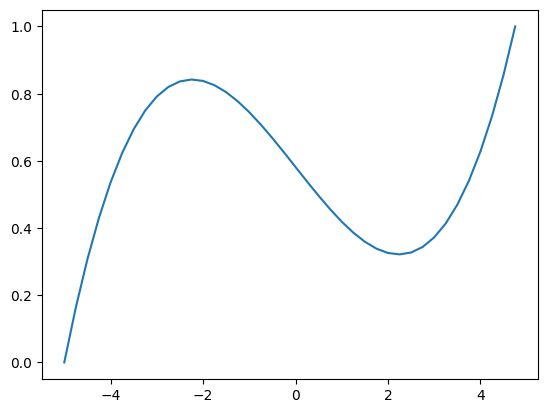

In [13]:
# try with toy dataset

def f(x):
    return (1/5)*x**3 - 3*x + 4

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
# min max scaling to ys to be in [0, 1]
ys = (ys - ys.min())/(ys.max() - ys.min())

plt.plot(xs, ys)

In [14]:
xs = [[x] for x in xs]

In [15]:
mlp = MLP(1, [8, 1])
lr=0.05
nepochs=5000

train(mlp, xs, ys, lr, nepochs)

Epoch [1/5000] | Loss: 2.275628
Epoch [2/5000] | Loss: 2.091412
Epoch [3/5000] | Loss: 2.007202
Epoch [4/5000] | Loss: 1.962571
Epoch [5/5000] | Loss: 1.934013
Epoch [6/5000] | Loss: 1.913010
Epoch [7/5000] | Loss: 1.896116
Epoch [8/5000] | Loss: 1.881661
Epoch [9/5000] | Loss: 1.868733
Epoch [10/5000] | Loss: 1.856811
Epoch [11/5000] | Loss: 1.845598
Epoch [12/5000] | Loss: 1.834918
Epoch [13/5000] | Loss: 1.824673
Epoch [14/5000] | Loss: 1.814798
Epoch [15/5000] | Loss: 1.805250
Epoch [16/5000] | Loss: 1.795996
Epoch [17/5000] | Loss: 1.787004
Epoch [18/5000] | Loss: 1.778246
Epoch [19/5000] | Loss: 1.769692
Epoch [20/5000] | Loss: 1.761312
Epoch [21/5000] | Loss: 1.753077
Epoch [22/5000] | Loss: 1.744960
Epoch [23/5000] | Loss: 1.736932
Epoch [24/5000] | Loss: 1.728968
Epoch [25/5000] | Loss: 1.721046
Epoch [26/5000] | Loss: 1.713146
Epoch [27/5000] | Loss: 1.705250
Epoch [28/5000] | Loss: 1.697343
Epoch [29/5000] | Loss: 1.689414
Epoch [30/5000] | Loss: 1.681454
Epoch [31/5000] | L

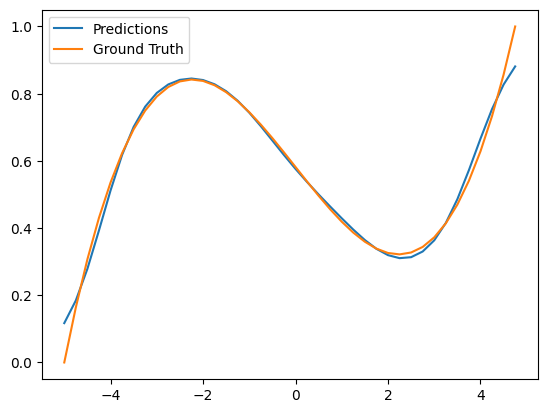

In [16]:
y_preds = [mlp(x) for x in xs]
# show boty the ground truth and the predictions
plt.plot(xs, [y.data for y in y_preds])
plt.plot(xs, ys)
plt.legend(['Predictions', 'Ground Truth'])

In [17]:
loss = sum([(yp - yt)**2 for yp, yt in zip(y_preds, ys)]) # mse loss
loss

Value(data=0.036575607469353996)